In [13]:
from mmdet3d.apis import inference_mono_3d_detector, init_model
%load_ext autoreload
%autoreload 2

# Copyright (c) OpenMMLab. All rights reserved.
import warnings
from copy import deepcopy
from os import path as osp
from pathlib import Path
from typing import Optional, Sequence, Union

import mmengine
import numpy as np
import torch
import torch.nn as nn
from mmengine.config import Config
from mmengine.dataset import Compose, pseudo_collate
from mmengine.registry import init_default_scope
from mmengine.runner import load_checkpoint

from mmdet3d.registry import DATASETS, MODELS
from mmdet3d.structures import Box3DMode, Det3DDataSample, get_box_type
from mmdet3d.structures.det3d_data_sample import SampleList
import mmcv
import cv2
from sensus.tools.visualizer import ImageVisualizer
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
def make_inferences(model_info, frames, mono_img_info):
    # model_info: dict
    config_file = model_info['config_file']
    checkpoint_file=model_info['checkpoint_file']
    device=model_info['device']
    # ann_file = model_info['ann_file']
    imgs = model_info['img_file']
    cam_type = model_info['cam_type']

    model = init_model(config_file, checkpoint_file, device=device)
    if isinstance(imgs, (list, tuple)):
        is_batch = True
    else:
        imgs = [imgs]
        is_batch = False
    cfg = model.cfg
    # build the data pipeline
    test_pipeline = deepcopy(cfg.test_dataloader.dataset.pipeline)
    test_pipeline = Compose(test_pipeline)
    box_type_3d, box_mode_3d = \
        get_box_type(cfg.test_dataloader.dataset.box_type_3d)

    # data_list = mmengine.load(ann_file)
    # assert len(imgs) == len(data_list)

    data = []
    img = imgs[0]
    index = 0
    # get data info containing calib
    # data_info = data_list[index]
    # img_path = data_info['images'][cam_type]['img_path']
    # if osp.basename(img_path) != osp.basename(img):
    #     raise ValueError(f'the info file of {img_path} is not provided.')
    
    # # replace the img_path in data_info with img
    # data_info['images'][cam_type]['img_path'] = img

    # avoid data_info['images'] has multiple keys anout camera views.
    # mono_img_info = {f'{cam_type}': data_info['images'][cam_type]}

    data_ = dict(
        images=mono_img_info,
        box_type_3d=box_type_3d,
        box_mode_3d=box_mode_3d)
    
    data_ = test_pipeline(data_)
    data = []

    results = []

    for frame in frames:
        data_['inputs']['img'] = frame
        data = []
        data.append(data_)

        collate_data = pseudo_collate(data)

        # forward the model
        with torch.no_grad():
            result = model.test_step(collate_data)
        results.append(result)

    return results
    

In [39]:
def draw_results(frames, results, calib, pitch, cam2img):
    images = []
    # Transforming the list
    transformed_list = [0.0] * 12  # Initialize a list of 12 zeros

    # Filling in the values from the original list
    transformed_list[0:3] = cam2img[0]
    transformed_list[4:7] = cam2img[1]
    transformed_list[8:11] = cam2img[2]
    for i in range(len(frames)):
        viz = ImageVisualizer()
        img = frames[i].permute(1, 2, 0).numpy()
        viz.image = img
        viz.load_calib(calib)
        # viz.calib['P2'] = cam2img
        # viz.calib['P2'] = cam2img
        print(viz.calib)
        result = results[i][0]
        viz.load_results(result)
        img = viz.draw_monodetection_results(score = 0.2, pitch = pitch, name = 'result_test_' + str(i) + '.png')
        images.append(img)

    
    # Assuming all frames have the same dimensions, get the height and width from the first frame
    height, width, _ = images[0].shape
    frame_size = (width, height)  # Width, Height for cv2.VideoWriter
    frame_size = (1920, 1080)

    # Define the output video path and FPS
    output_video_path = 'output_video.mp4'
    fps = 1  # Frames per second

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # You may also use 'avc1' or 'x264' depending on your system
    video_writer = cv2.VideoWriter(output_video_path, fourcc, fps, frame_size)

    # Write each frame to the video
    for image in images:

        # Display the BGR image using matplotlib (it will look incorrect in colors)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.show()

        # Write the BGR frame to the video
        video_writer.write(image)

    # Release the VideoWriter
    video_writer.release()

In [16]:
def process_video(video_path):
    video = mmcv.VideoReader(video_path)
    frames = []
    frames2 = []
    frames2.append(video[1130])
    frames2.append(video[1250])
    for frame in frames2:
        # Convert numpy array to a PyTorch tensor
        torch_image = torch.tensor(frame, dtype=torch.uint8)
        torch_image = torch_image.permute(2, 0, 1)
        frames.append(torch_image)
    return frames

In [17]:
ann_file = '/home/javier/sensus-loci/sensus/notebooks/002238.pkl'
img_path = '/home/javier/sensus-loci/sensus/notebooks/002238.png'
cam_type = 'CAM_BACK'
pitch = 0.2031

config_file = '/home/javier/sensus-loci/sensus/configs/smoke/smoke_dla34_dlaneck_gn-all_4xb8-6x_dair-mono3d_pretrained_kitty.py'
checkpoint_file = '/home/javier/sensus-loci/work_dirs/smoke_dla34_dlaneck_gn-all_4xb8-6x_dair-mono3d_pretrained_kitty/epoch_100.pth'
device = 'cuda:0'

model_info = dict(
    config_file=config_file,
    checkpoint_file=checkpoint_file,
    device=device,
    ann_file=ann_file,
    img_file=img_path,
    cam_type=cam_type,
)

video_path = '/home/javier/sensus-loci/output.mp4'
cam2img = [[2183.375019, 0.0, 940.590363], 
           [0.0, 2329.297332, 567.568513], 
           [0.0, 0.0, 1.0]]
img_info = {'CAM_BACK': {'img_path': '/home/javier/sensus-loci/sensus/notebooks/002238.png', 'cam2img': cam2img}}

In [38]:
frames = process_video(video_path)
cam2img = [[2183.375019, 0.0, 940.590363], 
           [0.0, 2329.297332, 567.568513], 
           [0.0, 0.0, 1.0]]
img_info = {'CAM_BACK': {'img_path': '/home/javier/sensus-loci/sensus/notebooks/002238.png', 'cam2img': cam2img}}
results = make_inferences(model_info, frames, img_info);
draw_results(frames, results, calib_file, pitch, cam2img)

Loads checkpoint by local backend from path: /home/javier/sensus-loci/work_dirs/smoke_dla34_dlaneck_gn-all_4xb8-6x_dair-mono3d_pretrained_kitty/epoch_100.pth
11/10 19:01:49 - mmengine - INFO - ModulatedDeformConvPack neck.dla_up.ida_0.projs.0.conv is upgraded to version 2.
11/10 19:01:49 - mmengine - INFO - ModulatedDeformConvPack neck.dla_up.ida_0.nodes.0.conv is upgraded to version 2.
11/10 19:01:49 - mmengine - INFO - ModulatedDeformConvPack neck.dla_up.ida_1.projs.0.conv is upgraded to version 2.
11/10 19:01:49 - mmengine - INFO - ModulatedDeformConvPack neck.dla_up.ida_1.projs.1.conv is upgraded to version 2.
11/10 19:01:49 - mmengine - INFO - ModulatedDeformConvPack neck.dla_up.ida_1.nodes.0.conv is upgraded to version 2.
11/10 19:01:49 - mmengine - INFO - ModulatedDeformConvPack neck.dla_up.ida_1.nodes.1.conv is upgraded to version 2.
11/10 19:01:49 - mmengine - INFO - ModulatedDeformConvPack neck.dla_up.ida_2.projs.0.conv is upgraded to version 2.
11/10 19:01:49 - mmengine - IN

ValueError: cannot reshape array of size 9 into shape (3,4)

In [9]:
print(len(results))

2


{'P2': [2183.375019, 0.0, 940.590363, 0.0, 0.0, 2329.297332, 567.568513, 0.0, 0.0, 0.0, 1.0, 0.0], 'R0_rect': [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0], 'Tr_velo_to_cam': [-0.03030349774397828, -1.00458142729985, -0.014115943716385967, -2.256601052723574, -0.22437570965542747, 0.0035552292126834464, -0.8538802187818876, 5.633608625376564, 0.9740701880036601, -0.04242754550762507, -0.203730541714936, 1.9350541378597665]}
{'P2': [2183.375019, 0.0, 940.590363, 0.0, 0.0, 2329.297332, 567.568513, 0.0, 0.0, 0.0, 1.0, 0.0], 'R0_rect': [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0], 'Tr_velo_to_cam': [-0.03030349774397828, -1.00458142729985, -0.014115943716385967, -2.256601052723574, -0.22437570965542747, 0.0035552292126834464, -0.8538802187818876, 5.633608625376564, 0.9740701880036601, -0.04242754550762507, -0.203730541714936, 1.9350541378597665]}


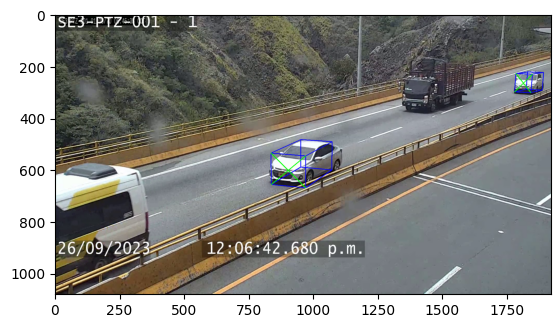

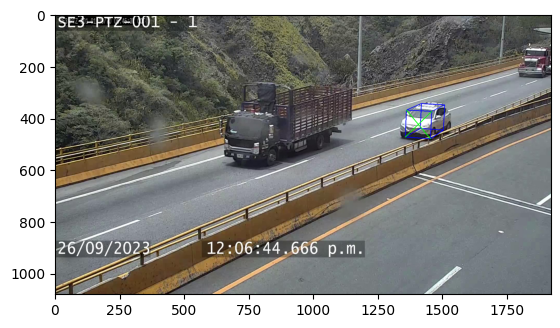

In [12]:
calib_file = '/home/javier/datasets/DAIR/single-infrastructure-side-mmdet/training/calib/002238.txt'

draw_results(frames, results, calib_file, pitch, cam2img)

In [47]:
if frames[1].is_cuda:
        torch_image = frames[1].cpu()
        
# Convert it from CHW to HWC format and then to a numpy array
numpy_image = frames[1].permute(1, 2, 0).numpy()

In [48]:
cv2.imwrite('test.png', numpy_image)

True